<a href="https://colab.research.google.com/github/nishanthnandakumar/Advanced-Deep-Learning/blob/main/ADL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ECG Heartbeat Categorization Dataset**

The dataset used in this project is from [kaggle](https://www.kaggle.com/shayanfazeli/heartbeat). The dataset consists of two collections of heartbeat signals which are derived from two datasets in heartbeat classification, [MIT-BIH Arrhythmia Database](https://www.physionet.org/content/mitdb/1.0.0/) and [PTB Diagnostic ECG Database](https://www.physionet.org/content/ptbdb/1.0.0/). The number of samples in both the datasets is enough to train a deep neural network.

This dataset is used in exploring heartbeat classification. The signals correspond to electrocardiogram (ECG) shapes of heartbeats for the normal case and the cases affected by different arrhythmias and myocardial infraction. These signals are preprocessed and segmented, with each segment correspoding to a heartbeat.

***Content***

***Arrhythmia Dataset***



*   Number of Samples: 109446
*   Number of Categories: 5
*   Sampling Frequency: 125Hz
*   Data Source: Physionet's MIT-BIH Arrhythmia Dataset
*   Classes: ['N':0, 'S':1, 'V':2, 'F':3, 'Q':4]

***The PTB Diagnostic ECG Database***



*   Number of Samples: 14552
*   Number of Categories: 2
*   Sampling Frequency: 125Hz
*   Data Source: Physionet's PTB Diagnostic Dataset

All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.



In [2]:
!pip install --user tensorflow-addons==0.8.3
!pip install --user tensorflow==2.2.0-rc3

     |████████████████████████████████| 1.0MB 15.3MB/s 
     |████████████████████████████████| 516.2MB 34kB/s 
     |████████████████████████████████| 460kB 48.1MB/s 
     |████████████████████████████████| 2.9MB 9.1MB/s 
     |████████████████████████████████| 3.0MB 34.5MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import zipfile
import pandas as pd
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn
import itertools
from tensorflow_addons.optimizers import CyclicalLearningRate
import matplotlib as mpl
mpl.style.use('seaborn')

In [2]:
#Download the dataset from kaggle and upload it to your drive which can be mounted here
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
#Unzip the data
local_zip = '/content/gdrive/My Drive/archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/ecg')
zip_ref.close()

**Import and Analyse data**

MIT-BIH Arhythmia dataset

In [4]:
#read the .csv files 
mitbih_test = pd.read_csv("./ecg/mitbih_test.csv", header=None)
mitbih_train = pd.read_csv("./ecg/mitbih_train.csv", header=None)

In [5]:
mitbih_train.shape

(87554, 188)

In [6]:
mitbih_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,0.030992,0.028926,0.035124,0.026860,0.039256,0.035124,0.043388,0.047521,0.053719,0.053719,0.070248,0.072314,0.084711,0.097107,0.121901,0.132231,0.169421,0.196281,0.214876,0.235537,0.254132,0.264463,0.285124,0.272727,0.266529,0.239669,0.214876,0.173554,0.157025,0.123967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,0.304029,0.336996,0.377289,0.391941,0.439560,0.446886,0.457875,0.479853,0.512821,0.534799,0.586081,0.586081,0.604396,0.633700,0.615385,0.582418,0.564103,0.520147,0.490842,0.490842,0.468864,0.454212,0.450549,0.465201,0.450549,0.432234,0.424908,0.410256,0.391941,0.369963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,0.106195,0.141593,0.128319,0.150442,0.132743,0.150442,0.132743,0.150442,0.123894,0.163717,0.137168,0.141593,0.132743,0.150442,0.128319,0.146018,0.119469,0.123894,0.101770,0.092920,0.070796,0.079646,0.066372,0.070796,0.079646,0.092920,0.088496,0.084071,0.079646,0.088496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,0.102083,0.122917,0.150000,0.168750,0.172917,0.170833,0.168750,0.164583,0.156250,0.152083,0.147917,0.147917,0.145833,0.145833,0.141667,0.141667,0.147917,0.158333,0.168750,0.179167,0.191667,0.206250,0.220833,0.239583,0.258333,0.275000,0.287500,0.308333,0.320833,0.331250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,0.080537,0.104027,0.093960,0.117450,0.097315,0.134228,0.124161,0.161074,0.171141,0.194631,0.204698,0.261745,0.275168,0.332215,0.345638,0.395973,0.406040,0.456376,0.446309,0.446309,0.399329,0.369128,0.308725,0.295302,0.265101,0.271812,0.258389,0.268456,0.261745,0.281879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
mitbih_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,0.052632,0.140351,0.119298,0.091228,0.140351,0.161404,0.105263,0.143860,0.143860,0.129825,0.147368,0.157895,0.164912,0.168421,0.154386,0.175439,0.164912,0.154386,0.182456,0.192982,0.196491,0.207018,0.217544,0.217544,0.256140,0.284211,0.294737,0.301754,0.301754,0.322807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,0.078333,0.183333,0.275000,0.315000,0.361667,0.430000,0.481667,0.526667,0.543333,0.563333,0.581667,0.588333,0.600000,0.603333,0.613333,0.6216

In [8]:
#Explore feature and label distribution
#As already mentioned we have 5 classes
mitbih_labels = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
#here we change the value key in the dictionary
mitbih_reverse_labels = {v:k for k,v in mitbih_labels.items()}
#The last column contains the labels
mitbih_train_labels = mitbih_train.iloc[:,-1].replace(mitbih_reverse_labels)

In [9]:
mitbih_train_labels

0        N
1        N
2        N
3        N
4        N
        ..
87549    Q
87550    Q
87551    Q
87552    Q
87553    Q
Name: 187, Length: 87554, dtype: object

Text(0.5, 1.0, 'Label distribution in MIT-BIH Arhythmia dataset')

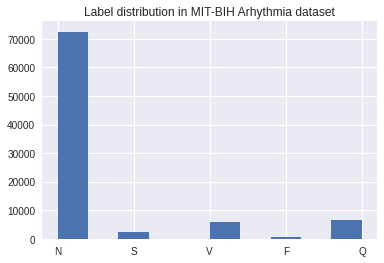

In [10]:
#plot the data according to label distribution
plt.hist(mitbih_train_labels)
plt.title("Label distribution in MIT-BIH Arhythmia dataset")

Text(0.5, 1.0, 'MIT-BIH Arrhythmia Dataset example signal')

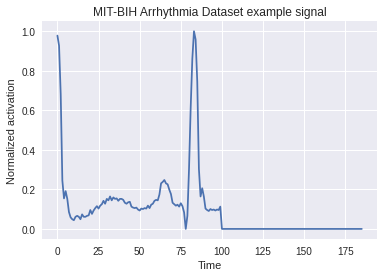

In [11]:
#Plot the example signal
plt.plot(mitbih_train.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("MIT-BIH Arrhythmia Dataset example signal")

In [12]:
#Now we should explore the data quality for NAN's and check if the data is normalized
print("There are {} NAN values in the train data.".format(mitbih_train.isna().sum().sum()))
print("There are {} NAN values in the test data.".format(mitbih_test.isna().sum().sum()))

There are 0 NAN values in the train data.
There are 0 NAN values in the test data.


In [13]:
print("The minimum and maximum values in the train dataset are {}, {}".format(np.min(mitbih_train.iloc[:,:-2].values), np.max(mitbih_train.iloc[:,:-2].values)))
print("The minimum and maximum values in the test dataset are {}, {}".format(np.min(mitbih_test.iloc[:,:-2].values), np.max(mitbih_test.iloc[:,:-2].values)))

The minimum and maximum values in the train dataset are 0.0, 1.0
The minimum and maximum values in the test dataset are 0.0, 1.0


**PTB Diagnostic ECG Database**

In [14]:
ptbdb_abnormal = pd.read_csv("./ecg/ptbdb_abnormal.csv", header=None)
ptbdb_normal = pd.read_csv("./ecg/ptbdb_normal.csv", header=None)
ptbdb = pd.concat([ptbdb_abnormal, ptbdb_normal], axis=0, ignore_index=True)

In [15]:
ptbdb.shape

(14552, 188)

In [16]:
ptbdb

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,0.649870,0.635100,0.655083,0.664639,0.633362,0.746308,0.871416,0.938314,1.000000,0.948740,0.396177,0.000000,0.039096,0.128584,0.305821,0.640313,0.617724,0.537793,0.352737,0.220678,0.256299,0.357950,0.482189,0.570808,0.577758,0.620330,0.622068,0.618593,0.626412,0.612511,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,0.125101,0.129136,0.137207,0.137207,0.132365,0.126715,0.158192,0.152542,0.132365,0.168684,0.156578,0.183212,0.191283,0.204197,0.230024,0.244552,0.285714,0.307506,0.321227,0.327684,0.351897,0.373688,0.397094,0.363196,0.340597,0.307506,0.258273,0.197740,0.199354,0.173527,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,0.681260,0.616743,0.624424,0.619816,0.596006,0.627496,0.631336,0.619048,0.612903,0.613671,0.607527,0.586790,0.568356,0.543779,0.526882,0.552995,0.577573,0.592166,0.576037,0.579109,0.573733,0.589862,0.542243,0.519201,0.514593,0.528418,0.493856,0.485407,0.461598,0.478495,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,0.357671,0.379852,0.375231,0.397412,0.388170,0.378004,0.398336,0.419593,0.427911,0.402033,0.378928,0.400185,0.406654,0.422366,0.402033,0.383549,0.398336,0.393715,0.417745,0.388170,0.360444,0.402957,0.392791,0.413124,0.377079,0.327172,0.346580,0.338262,0.356747,0.314233,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,0.285566,0.343718,0.281412,0.281412,0.283489,0.281412,0.319834,0.311526,0.283489,0.278297,0.274143,0.317757,0.267913,0.275182,0.280374,0.255452,0.313603,0.266874,0.244029,0.198339,0.192108,0.190031,0.134995,0.086189,0.078920,0.036345,0.024922,0.000000,0.044652,0.024922,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14547,1.000000,0.929586,0.503550,0.293491,0.169822,0.159763,0.130769,0.125444,0.137278,0.111243,0.134911,0.138462,0.134911,0.136095,0.121893,0.139645,0.134911,0.111834,0.111834,0.093491,0.125444,0.128402,0.137278,0.154438,0.150296,0.192899,0.192899,0.200592,0.224260,0.224852,0.294675,0.291124,0.297633,0.330769,0.331953,0.378107,0.366864,0.365680,0.364497,0.331361,...,0.097633,0.081657,0.124852,0.117

In [17]:
#Abnormal is labelled one as per convection
ptbdb_abnormal.values[:,-1]

array([1., 1., 1., ..., 1., 1., 1.])

In [18]:
#We need to explore features and labels
ptbdb_labels = {'Normal': 0, 'Abnormal': 1}
ptbdb_reverse_labels = {v:k for k,v in ptbdb_labels.items()}
ptbdb_labels = ptbdb.iloc[:,-1].replace(ptbdb_reverse_labels)

In [19]:
ptbdb_labels

0        Abnormal
1        Abnormal
2        Abnormal
3        Abnormal
4        Abnormal
           ...   
14547      Normal
14548      Normal
14549      Normal
14550      Normal
14551      Normal
Name: 187, Length: 14552, dtype: object

Text(0.5, 1.0, 'Label Distribution in PTB Diagnostics dataset')

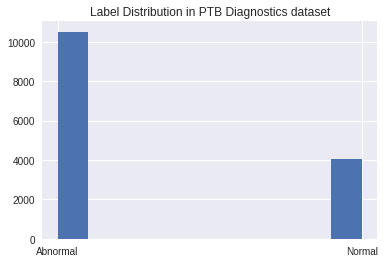

In [20]:
#let us now plot the dataset based on classes
plt.hist(ptbdb_labels)
plt.title("Label Distribution in PTB Diagnostics dataset")

In [21]:
#Exploring the data quality
#we check for NAN and normalization

print("There are {} nan values in the ptb data.".format(ptbdb_abnormal.isna().sum().sum()))

There are 0 nan values in the ptb data.


In [22]:
print("The minimum and maximum values are {}, {}".format(np.min(ptbdb.iloc[:,:-2].values), np.max(ptbdb.iloc[:,:-2].values)))

The minimum and maximum values are 0.0, 1.0


Text(0.5, 1.0, 'PTB Diagnostic ECG Database example signal')

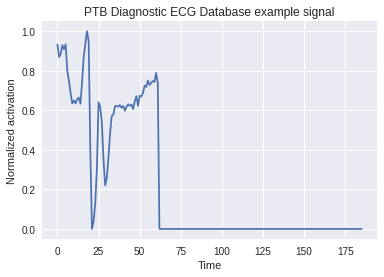

In [23]:
plt.plot(ptbdb.iloc[0,:-2])
plt.xlabel('Time')
plt.ylabel('Normalized activation')
plt.title("PTB Diagnostic ECG Database example signal")

# **Anomaly Detection and Condition Monitoring**

The main goal in this advancement of technology is to use technology and data to increase productivity and efficiency. We should be able to use the vast amounts of available data and actually extract useful information, making it posiible to reduce costs, optimize capacity, and keep downtime to a minimum.

***Anamoly Detection***

Anomaly detection (or outlier detection) is the identification of rare items, events or observations which raise suspicions by differing significantly from the majority of the data. The anomalous data can be connected to some kind of problem or rare event such as e.g. bank fraud, medical problems, structural defects, malfunctioning equipment, etc. This connection makes it very interesting to be able to pick out which data points can be considered anomalies, as identifying these events are typically very interesting from a business perspective.

Thi brings us to a key objective as how to identify whether data points are normal or anomalous? In some cases data visualization can give us important information. But this is very complicated in some cases so we will have to use different approaches for anomaly detection.

***Condition Monitoring***

Identifying the "health state" of an equipment is the domain of condition monitoring. The most common way to perform condition monitoring is to look at each sensor measurement from the machine and to impose a minimum and maximum value limit on it. If the current value is within the bounds, then the machine is healthy. If the current value is outside the bounds, then the machine is unhealthy and an alarm is sent.

This is not a good solution asthe health of a complex piece of equipment cannot be reliably judged based on the analysis of each measurement on its own. We must rather consider a combination of the various measurements to get a true indication of the situation.

There are multiple approaches for anomaly detection you can refer [here](https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7) for more details.

*Approach 1: Multivariate statistical analysis*



*   Dimensionality reduction using principal component analysis: PCA
*   Multivariate anomaly detection
*   The Mahalanobis distance

*Approach 2: Artificial Neural Network*

*   Autoencoder networks




As described above the problem at hand can be solved by any of the two approaches. For our ECG dataset we will be solving this by using Artificial Neural Networks.

In [24]:
#We need some helper functions which are obtained from https://github.com/avanwyk/tensorflow-projects/blob/master/lr-finder/lr_finder.py
#Apache License 2.0

from tensorflow.keras.callbacks import Callback

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-7, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

In [25]:
def pretty_plot(history, field, fn):
  def plot(data, val_data, best_index, best_value, title):
    plt.plot(range(1, len(data)+1), data, label='train')
    plt.plot(range(1, len(data)+1), val_data, label='validation')
    if not best_index is None:
      plt.axvline(x=best_index+1, linestyle=':', c="#777777")
    if not best_value is None:
      plt.axhline(y=best_value, linestyle=':', c="#777777")
    plt.xlabel('Epoch')
    plt.ylabel(field)
    plt.xticks(range(0, len(data), 20))
    plt.title(title)
    plt.legend()
    plt.show()

  data = history.history[field]
  val_data = history.history['val_' + field]
  tail = int(0.15 * len(data))

  best_index = fn(val_data)
  best_value = val_data[best_index]

  plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
  plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
#The Baseline MLP

def get_base_model(categories=2):
  return keras.Sequential([
    keras.layers.Dense(15, activation='relu', input_shape=[187], kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
    keras.layers.Dense(5, activation='relu'),
    (keras.layers.Dense(1, activation='sigmoid') if categories == 2 else keras.layers.Dense(5, activation='softmax'))                   
  ])

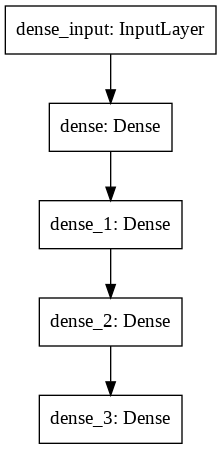

In [28]:
tf.keras.utils.plot_model(
    get_base_model(),
    to_file="model.png")

In [29]:
#Baseline PTB check

X_ptbdb_train, X_ptbdb_val, y_ptbdb_train, y_ptbdb_val = train_test_split(ptbdb.iloc[:,:-1].values, ptbdb.iloc[:,-1].values, test_size=0.2, random_state=42)
X_ptbdb_val, X_ptbdb_test, y_ptbdb_val, y_ptbdb_test  = train_test_split(X_ptbdb_val, y_ptbdb_val, test_size=0.5, random_state=42)

print("All features size {}".format(ptbdb.iloc[:,:-1].shape))
print("Train features size {}".format(X_ptbdb_train.shape))
print("Validation features size {}".format(X_ptbdb_val.shape))
print("Test features size {}".format(X_ptbdb_test.shape))

All features size (14552, 187)
Train features size (11641, 187)
Validation features size (1455, 187)
Test features size (1456, 187)


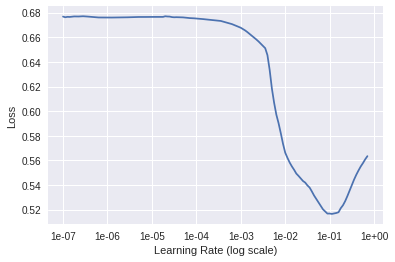

In [30]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_base_model() 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-2, max_steps=100, smoothing=0.6)
_ = model.fit(X_ptbdb_train, y_ptbdb_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [31]:
# Set cyclical learning rate
N = X_ptbdb_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-4, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

base_model = get_base_model() 
base_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = base_model.fit(X_ptbdb_train, y_ptbdb_train, validation_data=(X_ptbdb_val, y_ptbdb_val), 
                         shuffle=True, batch_size=batch_size, epochs=150, callbacks=[save_best_weights])

Epoch 1/150
91/91 [==============================] - 0s 4ms/step - loss: 0.5150 - accuracy: 0.7279 - val_loss: 0.4197 - val_accuracy: 0.8055
Epoch 2/150
91/91 [==============================] - 0s 2ms/step - loss: 0.3939 - accuracy: 0.8199 - val_loss: 0.3718 - val_accuracy: 0.8412
Epoch 3/150
91/91 [==============================] - 0s 3ms/step - loss: 0.3476 - accuracy: 0.8463 - val_loss: 0.3249 - val_accuracy: 0.8708
Epoch 4/150
91/91 [==============================] - 0s 2ms/step - loss: 0.2990 - accuracy: 0.8839 - val_loss: 0.3016 - val_accuracy: 0.8811
Epoch 5/150
91/91 [==============================] - 0s 3ms/step - loss: 0.2839 - accuracy: 0.8950 - val_loss: 0.2964 - val_accuracy: 0.8742
Epoch 6/150
91/91 [==============================] - 0s 2ms/step - loss: 0.2832 - accuracy: 0.8881 - val_loss: 0.2933 - val_accuracy: 0.8701
Epoch 7/150
91/91 [==============================] - 0s 3ms/step - loss: 0.2663 - accuracy: 0.8930 - val_loss: 0.2601 - val_accuracy: 0.8935
Epoch 8/150
9

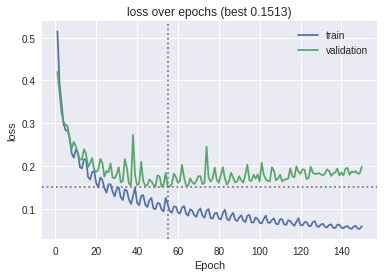

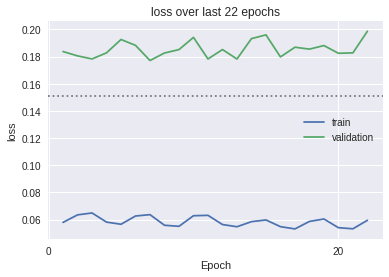

In [32]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

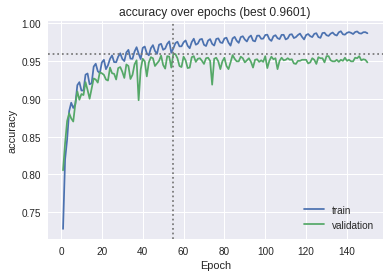

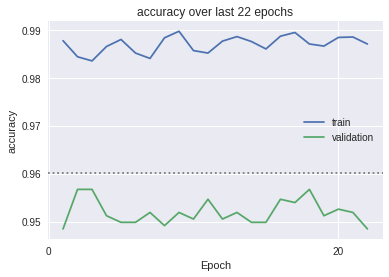

In [33]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [34]:
base_model.load_weights('weights.hdf5')
base_model.evaluate(X_ptbdb_test, y_ptbdb_test)

46/46 [==============================] - 0s 1ms/step - loss: 0.1559 - accuracy: 0.9512


[0.15587972104549408, 0.9512362480163574]

Confusion matrix, without normalization
[[ 346   39]
 [  32 1039]]


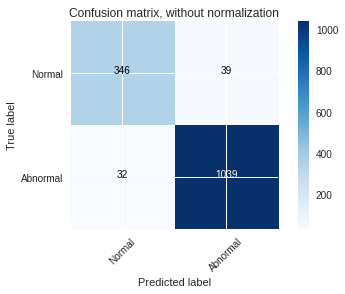

In [35]:
y_pred = (base_model.predict(X_ptbdb_test) > 0.5).astype("int32")

# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')

The above plots provide us the accuracy of the model both for training and the validation set. We also have the confusion matrix where we can observe the number of true positives and true negatives.

Now, we will be using the ResNet model to improve the performance on the dataset.

In [36]:
#ResNet model

def get_resnet_model(categories=2):
  def residual_block(X, kernels, stride):
    out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out)
    return out

  kernels = 32
  stride = 5

  inputs = keras.layers.Input([187,1])
  X = keras.layers.Conv1D(kernels, stride)(inputs)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 2 else keras.layers.Dense(5, activation='softmax')(X))

  model = keras.Model(inputs=inputs, outputs=output)
  return model

In [37]:
#ResNet PTB replication
X_ptbdbl_train = np.expand_dims(X_ptbdb_train, -1)
y_ptbdbl_train = np.expand_dims(y_ptbdb_train, -1)

X_ptbdbl_val = np.expand_dims(X_ptbdb_val, -1)
y_ptbdbl_val = np.expand_dims(y_ptbdb_val, -1)

X_ptbdbl_test = np.expand_dims(X_ptbdb_test, -1)
y_ptbdbl_test = np.expand_dims(y_ptbdb_test, -1)

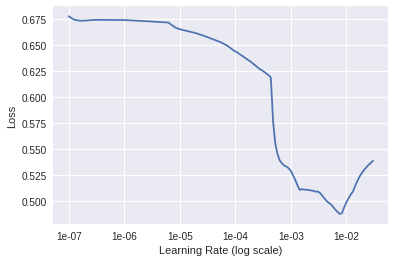

In [38]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model() 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-03, max_steps=100, smoothing=0.6)
_ = model.fit(X_ptbdbl_train, y_ptbdbl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [39]:
# Set cyclical learning rate
N = X_ptbdbl_train.shape[0]
batch_size = 128
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-6, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

resnet_model = get_resnet_model() 
resnet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = resnet_model.fit(X_ptbdbl_train, y_ptbdbl_train, validation_data=(X_ptbdbl_val, y_ptbdbl_val), 
                           shuffle=True, batch_size=batch_size, epochs=75, callbacks=[save_best_weights])

Epoch 1/75
91/91 [==============================] - 13s 138ms/step - loss: 0.5545 - accuracy: 0.7374 - val_loss: 0.3818 - val_accuracy: 0.8220
Epoch 2/75
91/91 [==============================] - 13s 138ms/step - loss: 0.3416 - accuracy: 0.8484 - val_loss: 0.2558 - val_accuracy: 0.9010
Epoch 3/75
91/91 [==============================] - 13s 139ms/step - loss: 0.2504 - accuracy: 0.9003 - val_loss: 0.1802 - val_accuracy: 0.9443
Epoch 4/75
91/91 [==============================] - 13s 138ms/step - loss: 0.1509 - accuracy: 0.9479 - val_loss: 0.1379 - val_accuracy: 0.9526
Epoch 5/75
91/91 [==============================] - 13s 137ms/step - loss: 0.1340 - accuracy: 0.9509 - val_loss: 0.1341 - val_accuracy: 0.9485
Epoch 6/75
91/91 [==============================] - 13s 138ms/step - loss: 0.1284 - accuracy: 0.9512 - val_loss: 0.1329 - val_accuracy: 0.9533
Epoch 7/75
91/91 [==============================] - 13s 138ms/step - loss: 0.0938 - accuracy: 0.9661 - val_loss: 0.0738 - val_accuracy: 0.9766

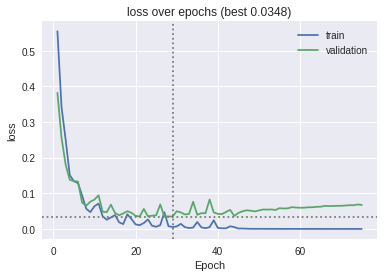

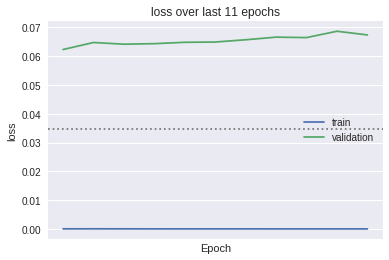

In [40]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

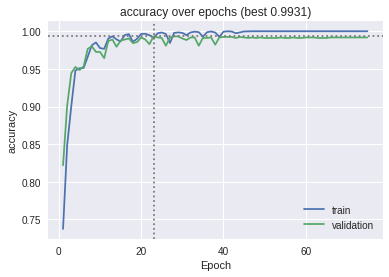

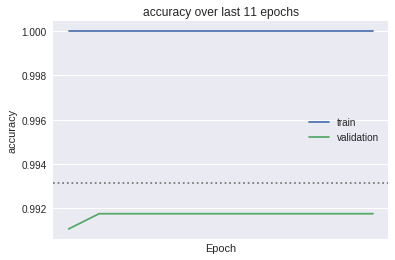

In [41]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [42]:
resnet_model.load_weights('weights.hdf5')
resnet_model.evaluate(X_ptbdbl_test, y_ptbdbl_test)

46/46 [==============================] - 1s 12ms/step - loss: 0.0129 - accuracy: 0.9938


[0.012943428941071033, 0.9938187003135681]

Confusion matrix, without normalization
[[ 383    2]
 [   7 1064]]


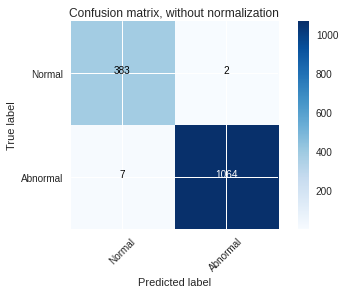

In [43]:
y_pred = (resnet_model.predict(X_ptbdbl_test) > 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')

The performance of the ResNet model is much better compared to the other model. The accuracy of the model is much better and as we can observe from the confusion matrix the false classification are reduced drastically for the PTB Diagnostic ECG Database.

Now, we will use the ResNet model for MIT-BIH database.

In [44]:
#ResNet MIT-BIH replication

X_mitbih_train, X_mitbih_val, y_mitbih_train, y_mitbih_val = train_test_split(mitbih_train.iloc[:,:-1].values, mitbih_train.iloc[:,-1].values, test_size=0.1, random_state=42)
X_mitbih_test = mitbih_test.iloc[:,:-1].values
y_mitbih_test = mitbih_test.iloc[:,-1].values

# The 1D convolutions expect an extra dimension in the input data 
X_mitbihl_train = np.expand_dims(X_mitbih_train, -1)
y_mitbihl_train = np.expand_dims(y_mitbih_train, -1)
X_mitbihl_val = np.expand_dims(X_mitbih_val, -1)
y_mitbihl_val = np.expand_dims(y_mitbih_val, -1)
X_mitbihl_test = np.expand_dims(X_mitbih_test, -1)
y_mitbihl_test = np.expand_dims(y_mitbih_test, -1)

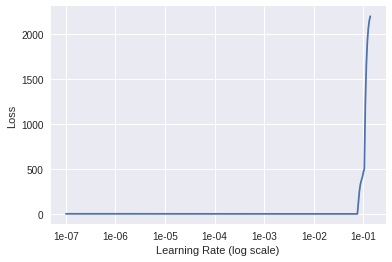

In [45]:
optimizer = keras.optimizers.Adam(lr=0.001)
model = get_resnet_model(5) 
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-06, max_steps=50, smoothing=0.6)
_ = model.fit(X_mitbihl_train, y_mitbihl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
lr_finder.plot()

In [46]:
lr_schedule = CyclicalLearningRate(1e-5, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
m_resnet_model = get_resnet_model(5)

save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = m_resnet_model.fit(X_mitbihl_train, y_mitbihl_train, validation_data=(X_mitbihl_val, y_mitbihl_val), 
                             shuffle=True, batch_size=128, epochs=50, callbacks=[save_best_weights])

Epoch 1/50
616/616 [==============================] - 87s 142ms/step - loss: 0.3434 - accuracy: 0.8931 - val_loss: 0.1693 - val_accuracy: 0.9519
Epoch 2/50
616/616 [==============================] - 89s 144ms/step - loss: 0.1413 - accuracy: 0.9607 - val_loss: 0.1617 - val_accuracy: 0.9518
Epoch 3/50
616/616 [==============================] - 90s 146ms/step - loss: 0.1143 - accuracy: 0.9688 - val_loss: 0.0983 - val_accuracy: 0.9716
Epoch 4/50
616/616 [==============================] - 91s 147ms/step - loss: 0.0960 - accuracy: 0.9741 - val_loss: 0.0951 - val_accuracy: 0.9728
Epoch 5/50
616/616 [==============================] - 91s 148ms/step - loss: 0.0810 - accuracy: 0.9778 - val_loss: 0.1211 - val_accuracy: 0.9669
Epoch 6/50
616/616 [==============================] - 93s 151ms/step - loss: 0.0738 - accuracy: 0.9793 - val_loss: 0.0743 - val_accuracy: 0.9783
Epoch 7/50
616/616 [==============================] - 96s 156ms/step - loss: 0.0687 - accuracy: 0.9808 - val_loss: 0.0721 - val_ac

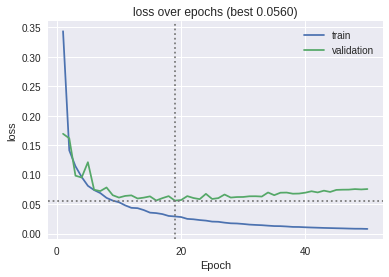

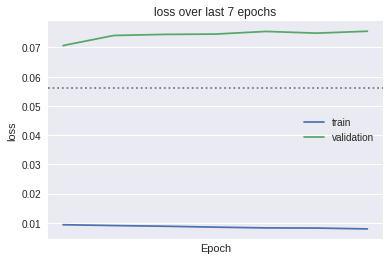

In [47]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

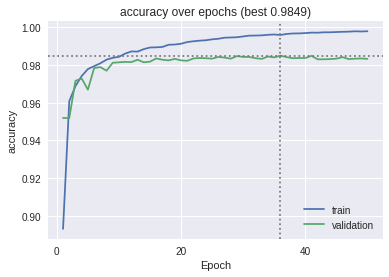

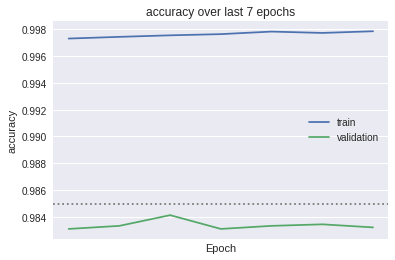

In [48]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [49]:
m_resnet_model.load_weights('weights.hdf5')
X_mitbih_test = m_resnet_model.evaluate(X_mitbihl_test, y_mitbihl_test)

685/685 [==============================] - 8s 12ms/step - loss: 0.0625 - accuracy: 0.9843


Confusion matrix, without normalization
[[18033    38    37     2     8]
 [  115   425    14     1     1]
 [   39     6  1384    11     8]
 [   28     0    13   121     0]
 [   16     1     5     0  1586]]


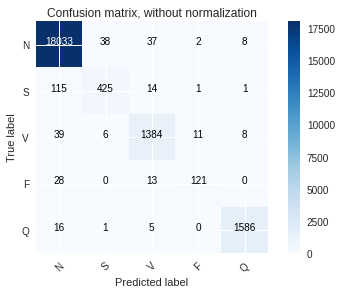

In [50]:
y_pred = tf.argmax(m_resnet_model.predict(X_mitbihl_test), axis=-1)
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_mitbih_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')

The performance of the model on the MIT-BIH database is as shown in the plots above. As we have 5 classes in the dataset the confusion matrix is 5x5 with diagonal elements being correctly classified as their respective labels.

Next, we will try to use transfer learning by using the ResNet model except the last three layers. To check its performance on the PTB diagnostic ECG Database.

In [51]:
#Transfer Learning
m_resnet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 183, 32)      192         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 183, 32)      5152        conv1d_33[0][0]                  
__________________________________________________________________________________________________
re_lu_30 (ReLU)                 (None, 183, 32)      0           conv1d_34[0][0]                  
____________________________________________________________________________________________

In [52]:
# Reuse the MIT trained model, except the last three layers
def get_transfer_model(model):
  model.trainable = False
  model_input = model.inputs
  model_output = model.layers[-4].output

  X = keras.layers.Dense(32, activation='relu')(model_output)
  X = keras.layers.Dense(32, activation='relu')(X)
  out = keras.layers.Dense(1, activation='sigmoid')(X)

  transfer_model = keras.Model(inputs=model_input, outputs=out)
  return transfer_model

get_transfer_model(m_resnet_model).summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 183, 32)      192         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 183, 32)      5152        conv1d_33[0][0]                  
__________________________________________________________________________________________________
re_lu_30 (ReLU)                 (None, 183, 32)      0           conv1d_34[0][0]                  
____________________________________________________________________________________________

In [53]:
optimizer = keras.optimizers.Adam(lr=0.001)
transfer_model = get_transfer_model(m_resnet_model)

save_best_weights = ModelCheckpoint(filepath="tweights.hdf5", verbose=0, save_best_only=True)

transfer_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = transfer_model.fit(X_ptbdbl_train, y_ptbdbl_train, validation_data=(X_ptbdbl_val, y_ptbdbl_val), 
                             shuffle=True, batch_size=128, epochs=100, callbacks=[save_best_weights])

Epoch 1/100
91/91 [==============================] - 4s 41ms/step - loss: 0.6611 - accuracy: 0.7369 - val_loss: 0.3828 - val_accuracy: 0.8337
Epoch 2/100
91/91 [==============================] - 4s 39ms/step - loss: 0.3698 - accuracy: 0.8348 - val_loss: 0.3444 - val_accuracy: 0.8515
Epoch 3/100
91/91 [==============================] - 4s 38ms/step - loss: 0.3323 - accuracy: 0.8569 - val_loss: 0.3127 - val_accuracy: 0.8612
Epoch 4/100
91/91 [==============================] - 3s 38ms/step - loss: 0.3015 - accuracy: 0.8705 - val_loss: 0.2927 - val_accuracy: 0.8749
Epoch 5/100
91/91 [==============================] - 4s 39ms/step - loss: 0.2810 - accuracy: 0.8779 - val_loss: 0.2695 - val_accuracy: 0.8838
Epoch 6/100
91/91 [==============================] - 4s 38ms/step - loss: 0.2629 - accuracy: 0.8877 - val_loss: 0.2518 - val_accuracy: 0.8907
Epoch 7/100
91/91 [==============================] - 4s 39ms/step - loss: 0.2512 - accuracy: 0.8916 - val_loss: 0.2420 - val_accuracy: 0.8859
Epoch 

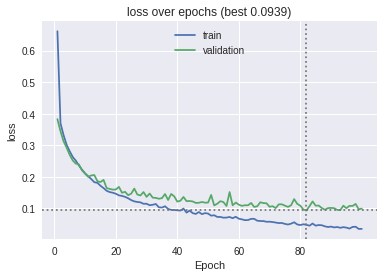

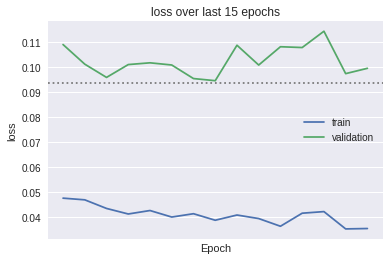

In [54]:
pretty_plot(history, 'loss', lambda x: np.argmin(x))

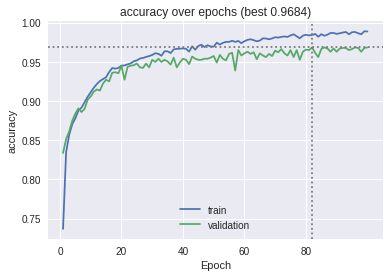

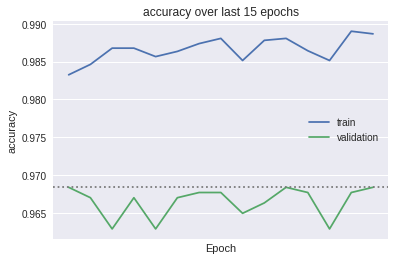

In [55]:
pretty_plot(history, 'accuracy', lambda x: np.argmax(x))

In [56]:
transfer_model.load_weights('tweights.hdf5')
transfer_model.evaluate(X_ptbdbl_test, y_ptbdb_test)

46/46 [==============================] - 1s 12ms/step - loss: 0.0780 - accuracy: 0.9712


[0.07803098857402802, 0.9711538553237915]

Confusion matrix, without normalization
[[ 363   22]
 [  20 1051]]


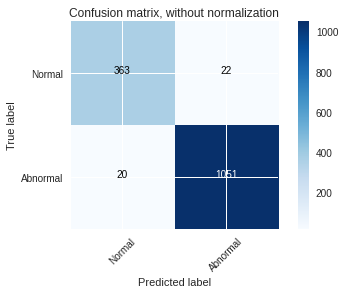

In [57]:
y_pred = (transfer_model.predict(X_ptbdbl_test) >= 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_ptbdb_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Normal', 'Abnormal'],
                      title='Confusion matrix, without normalization')

As can be observed we have the performance of the model and the confusion matrix for the model based on transfer learning.

# **Conclusion**

The main objective of this work was to classify the ECG Heartbeat data from  MIT-BIH Arrhythmia Database and PTB Diagnostic ECG Database using deep learning models. We have used three different models to train and validate them on the datasets. 

***Model Performance:***



1.   MLP Baseline Model: Accuracy 95.19% on PTB database
2.   ResNet Model: Accuracy 99.66% on PTB database
3.   ResNet Model: Accuracy 98.46% on MIT-BIH database
4.   ResNet Transfer Learning: 97.66% on PTB database

We can conclude that the performance of the ResNet model is much better than other models and false classification are reduced to a great extent.

